In [80]:
from util import *

def plot_time_space(exp, circumference=80, sim_step=0.5, save=None):
    all_pos = np.array([[veh['pos'] for veh in x['vehs']] for x in exp])
    for veh_i, veh_pos in enumerate(all_pos.T):
        curr_steps, curr_pos = [], []
        last = None
        for step, pos in enumerate(veh_pos):
            if last is not None and pos < last:
                plt.plot(curr_steps, curr_pos, color=plt_colors[veh_i], linewidth=1)
                curr_steps, curr_pos = [], []
            curr_steps.append(step)
            curr_pos.append(pos)
            last = pos
        plt.plot(curr_steps, curr_pos, color=plt_colors[veh_i], linewidth=1)
        plt.xlabel('step (%s s)' % sim_step)
        plt.ylabel('ring position (0 to %s m)' % circumference)
        plt.ylim([0, circumference])
        plt.xlim([0, step])
    if save is not None:
        plt.savefig(save)
    plt.show()

def plot_runtime(exp):
    times = [x['time'] for x in exp]
    plt.plot(times)
    plt.show()
    print('time/step', times[-1] / len(times))

def speeds(exp):
    speeds = [[veh['speed'] for veh in x['vehs']] for x in exp]
    print('Mean', np.mean(speeds))
    print('Std', np.std(speeds))
    print('Min', np.min(speeds))
    print('Max', np.max(speeds))
figures = Path('figures').mk()

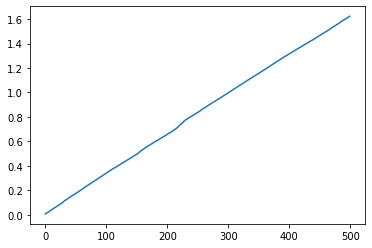

time/step 0.0032461557388305663


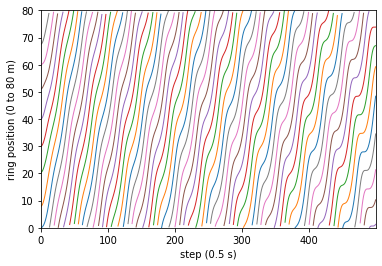

Mean 2.4214238923803504
Std 1.1605412417837364
Min 0.0
Max 4.509042777079846


In [81]:
baseline = Path('experiments/circ80_veh8_step0.5_baseline.json').load()
plot_runtime(baseline)
plot_time_space(baseline, save=figures / 'circ80_veh8_step0.5_baseline.svg')
speeds(baseline)

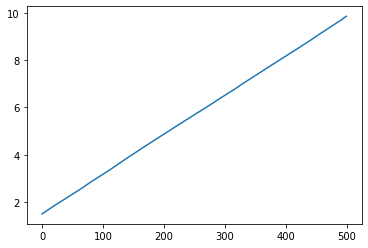

time/step 0.019702916145324708


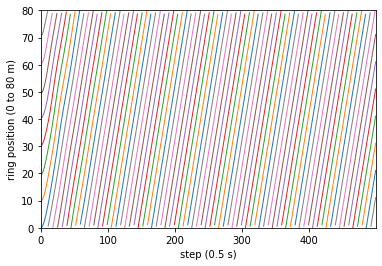

Mean 2.967127679926055
Std 0.24837955278957705
Min 0.0
Max 3.404407749899605
None


In [82]:
target1 = Path('experiments/circ80_veh8_step0.5_opt1_costtarget.json').load()
plot_runtime(target1)
plot_time_space(target1, save=figures / 'circ80_veh8_step0.5_opt1_costtarget.svg')
print(speeds(target1))

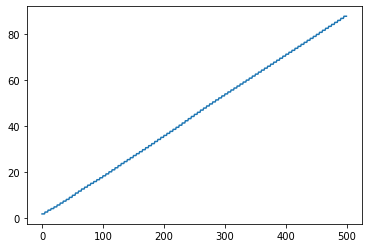

time/step 0.1755338044166565


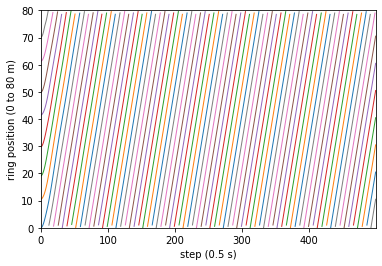

Mean 2.963960387733031
Std 0.2511286503017145
Min 0.0
Max 3.194992926287264


In [83]:
target5 = Path('experiments/circ80_veh8_step0.5_opt5_costtarget.json').load()
plot_runtime(target5)
plot_time_space(target5)
speeds(target5)

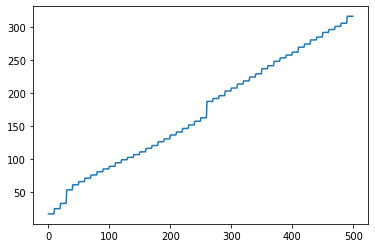

time/step 0.6328281378746032


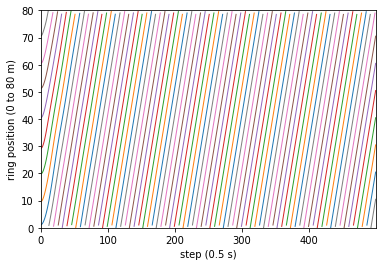

Mean 2.9637157749992395
Std 0.2517315448107529
Min 0.0
Max 3.282987812224027


In [84]:
target10 = Path('experiments/circ80_veh8_step0.5_opt10_costtarget.json').load()
plot_runtime(target10)
plot_time_space(target10)
speeds(target10)

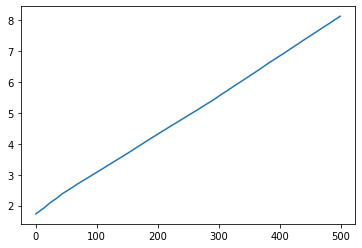

time/step 0.016272526264190675


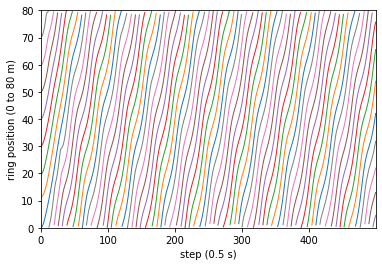

Mean 2.736448620436913
Std 0.849333299365583
Min 0.0
Max 4.184023657492635


In [100]:
mean1 = Path('experiments/circ80_veh8_step0.5_opt1_costmean.json').load()
plot_runtime(mean1)
plot_time_space(mean1, save=figures / 'circ80_veh8_step0.5_opt1_costmean.svg')
speeds(mean1)

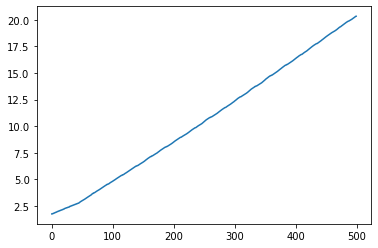

time/step 0.040663963794708255


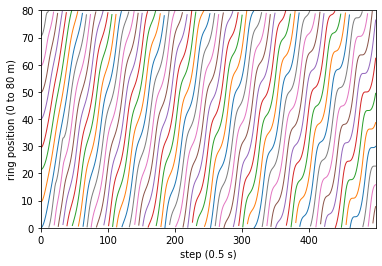

Mean 2.3734578886659965
Std 1.2036883709279993
Min 0.0
Max 4.525187490043723


In [86]:
mean2 = Path('experiments/circ80_veh8_step0.5_opt2_costmean.json').load()
plot_runtime(mean2)
plot_time_space(mean2)
speeds(mean2)

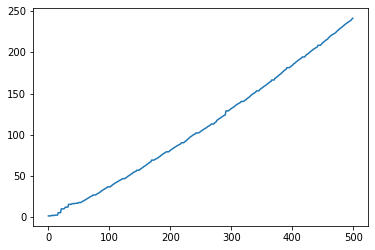

time/step 0.48271998739242555


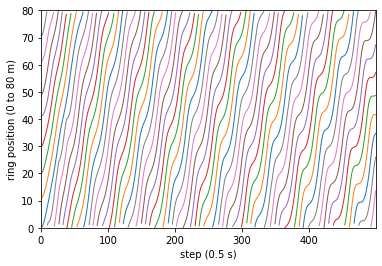

Mean 2.3651449531965736
Std 1.1938606337460866
Min 0.0
Max 4.504650368979454


In [99]:
mean5 = Path('experiments/circ80_veh8_step0.5_opt5_costmean.json').load()
plot_runtime(mean5)
plot_time_space(mean5, save=figures / 'circ80_veh8_step0.5_opt5_costmean.svg')
speeds(mean5)

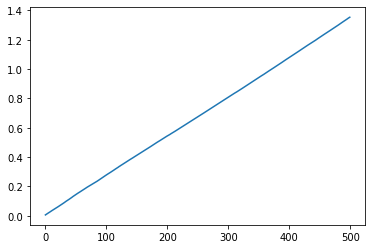

time/step 0.002706225872039795


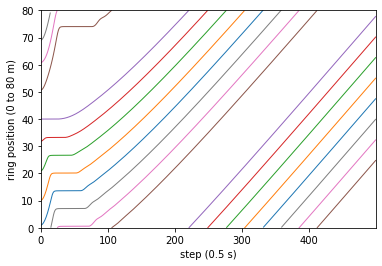

Mean 0.5029255092885992
Std 0.25540660799402704
Min 0.0
Max 2.6568931293691422


In [97]:
pid_long = Path('experiments/circ80_veh8_step0.5_pid_long.json').load()[:500]
plot_runtime(pid_long)
plot_time_space(pid_long, save=figures / 'circ80_veh8_step0.5_pid_long.svg')
speeds(pid_long)

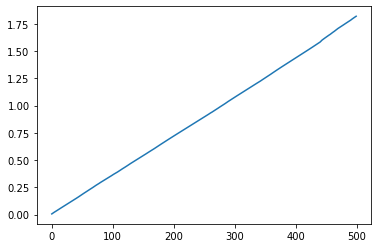

time/step 0.003639172077178955


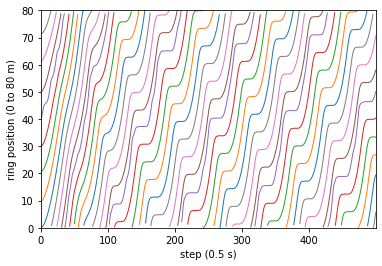

Mean 1.6505750721319714
Std 1.3400500754665927
Min 0.0
Max 5.733001733317151


In [98]:
pid_short = Path('experiments/circ80_veh8_step0.5_pid_short.json').load()[:500]
plot_runtime(pid_short)
plot_time_space(pid_short, save=figures / 'circ80_veh8_step0.5_pid_short.svg')
speeds(pid_short)

# Old

In [ ]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

from pydrake.all import (Variable, SymbolicVectorSystem, DiagramBuilder,
                         LogOutput, Simulator, ConstantVectorSource,
                         MathematicalProgram, Solve, 
                         OsqpSolver, MosekSolver, SnoptSolver, IpoptSolver,
                         PiecewisePolynomial, eq, le, ge)

from matplotlib import rcParams
rcParams['figure.figsize'] = (8, 5)

In [ ]:
n_veh = 8
L = 80

L_veh = 5
a = 1
b = 1.5
s0 = 2
v0 = 30
T = 1
delta = 4

In [ ]:
sf = L / n_veh - L_veh
accel_fn = lambda v: a * (1 - (v / v0) ** delta - ((s0 + v * T) / sf) ** 2)
sol = scipy.optimize.root(accel_fn, 0)
vf = sol.x.item()
sstarf = s0 + vf * T

In [ ]:
# get guesses for solutions
v_guess = [np.mean(v_init)]
for _ in range(N):
    v_guess.append(dt * accel_fn(v_guess[-1]))
s_guess = [sf] * (N + 1)

prog = MathematicalProgram()
v = prog.NewContinuousVariables(N + 1, n_veh, 'v') # speed
s = prog.NewContinuousVariables(N + 1, n_veh, 's') # spacing
flat = lambda x: x.reshape(-1)

# Guess
prog.SetInitialGuess(s, np.stack([s_guess] * n_veh, axis=1))
prog.SetInitialGuess(v, np.stack([v_guess] * n_veh, axis=1))

# initial conditions constraint
prog.AddLinearConstraint(eq(v[0], v_init))
prog.AddLinearConstraint(eq(s[0], s_init))

# velocity constraint
prog.AddLinearConstraint(ge(flat(v[1:]), 0))
prog.AddLinearConstraint(le(flat(v[1:]), vf + 1)) # extra constraint to help solver

# spacing constraint
prog.AddLinearConstraint(ge(flat(s[1:]), s0))
prog.AddLinearConstraint(le(flat(s[1:]), 10)) # extra constraint to help solver
prog.AddLinearConstraint(eq(flat(s[1:].sum(axis=1)), L - L_veh * n_veh))

# spacing update constraint
s_n = s[:-1, 1:]       # s_i[n]
s_np1 = s[1:, 1:]      # s_i[n + 1]
v_n = v[:-1, 1:]       # v_i[n]
v_np1 = v[1:, 1:]      # v_i[n + 1]
v_n_im1 = v[:-1, :-1]  # v_{i - 1}[n]
v_np1_im1 = v[1:, :-1] # v_{i - 1}[n + 1]
prog.AddLinearConstraint(eq(
    flat(s_np1 - s_n), flat(0.5 * dt * (v_n_im1 + v_np1_im1 - v_n - v_np1))))
# handle position wrap for vehicle 1
prog.AddLinearConstraint(eq(s[1:, 0] - s[:-1, 0], 0.5 * dt * (v[:-1, -1] + v[1:, -1] - v[:-1, 0] - v[1:, 0])))

# vehicle 0's action constraint
prog.AddLinearConstraint(ge(v[1:, 0], v[:-1, 0] - u_max * dt))
prog.AddLinearConstraint(le(v[1:, 0], v[:-1, 0] + u_max * dt))

# idm constraint
prog.AddConstraint(eq(
    (v_np1 - v_n - dt * a * (1 - (v_n / v0) ** delta)) * s_n ** 2,
    -dt * a * (s0 + v_n * T + v_n * (v_n - v_n_im1) / (2 * np.sqrt(a * b))) ** 2))

prog.AddCost(((v - vf) ** 2).mean() + ((s - sf) ** 2).mean())

solver = SnoptSolver()
result = solver.Solve(prog)

assert result.is_success()

In [ ]:
result.GetSolution()

In [ ]:
result.GetSolution(s)
# result.get_optimal_cost()

In [ ]:
result.GetSolution(v)

# Old

In [ ]:
import pydrake
import inspect
attrs = inspect.getmembers(pydrake.all, lambda a: not inspect.isroutine(a))
attrs

In [ ]:
N = 10
dt = 1
u_max = 1
x_init = [np.clip(np.random.normal(i * L / n_veh, 1), 0, np.inf) for i in reversed(range(n_veh))]

prog = MathematicalProgram()
v = prog.NewContinuousVariables(N + 1, n_veh, 'v') # speed
x = prog.NewContinuousVariables(N + 1, n_veh, 'x') # position
flat = lambda x: x.reshape(-1)

# initial conditions constraint
prog.AddLinearConstraint(eq(v[0], 0))
prog.AddLinearConstraint(eq(x[0], x_init))

# velocity constraint
prog.AddLinearConstraint(ge(flat(v[1:]), 0))
prog.AddLinearConstraint(le(flat(v[1:]), 3)) # extra

# position update constraint
prog.AddLinearConstraint(eq(
    flat(x[1:]),
    flat(x[:-1] + 0.5 * (v[:-1] + v[1:]) * dt)))

# vehicle position constraint
prog.AddLinearConstraint(le(flat(x[:, 1:]), flat(x[:, :-1] - (L_veh + s0))))
prog.AddLinearConstraint(le(x[:, 0], x[:, -1] - (L_veh + s0) + L)) # handle position wrap for vehicle 1

# vehicle 1's action constraint
prog.AddLinearConstraint(ge(v[1:, 0], v[:-1, 0] - u_max * dt))
prog.AddLinearConstraint(le(v[1:, 0], v[:-1, 0] + u_max * dt))

# idm constraint
v_i_n = v[:-1, 1:]
v_i_np1 = v[1:, 1:]
v_im1_n = v[:-1, :-1]
x_i_n = x[:-1, 1:]
x_im1_n = x[:-1, :-1]
# prog.AddLinearConstraint(eq(flat(v_i_np1 - v_i_n), flat(dt * a * (1 + v_i_n / v0 + \
#     (sstarf / sf) ** 2 + \
#     (2 * sstarf) / (sf ** 2) * (T + vf / (2 * np.sqrt(a * b))) * (v_i_n - vf) + \
#     -(2 * sstarf) / (sf ** 2) * (vf / (2 * np.sqrt(a * b))) * (v_im1_n - vf) + \
#     2 * (sstarf ** 2) / (sf ** 3) * (x_i_n - x_im1_n)
# ))))
prog.AddConstraint(eq(
    (v_i_np1 - v_i_n - dt * (1 - (v_i_n / v0) ** delta)) * (x_im1_n - x_i_n - L_veh) ** 2,
    -dt * a * (s0 + v_i_n * T + v_i_n * (v_i_n - v_im1_n) / (2 * np.sqrt(a * b))) ** 2))

prog.AddCost((v * v).mean())

print('Solving...')    
solve = OsqpSolver()
# solver = SnoptSolver()
result = solver.Solve(prog)

assert result.is_success()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from u import *
from time import sleep

In [ ]:
%matplotlib notebook
def setup_plot(vehicles):
    circle = plt.Circle((0, 0), radius, color='black', linewidth=10, fill=False)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.add_artist(circle)
    
    def update_plt(veh):
        angle = veh.pos / radius
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        slope = np.array([y, -x])
        offset = 0.5 * L_veh * slope / np.linalg.norm(slope)
        center = np.array([x, y])
        veh.plt_line.set_data(*zip(center + offset, center - offset))
        veh.plt_text.set_position((0.9 * x - 0.03 * radius, 0.95 * y - 0.03 * radius))
        
    import types
    for veh in vehicles:
        veh.update_plt = types.MethodType(update_plt, veh)
        veh.plt_line, = ax.plot([0, 1], [0, 1], color='gray', linewidth=4)
        veh.plt_text = ax.text(0, 0, f'{veh.i}', color='red', fontsize=20)
        veh.update_plt()
    plt.xlim((-radius - 5, radius + 5))
    plt.ylim((-radius - 5, radius + 5))

    text = plt.text(0, 0, '')
    def draw(t):
        texts = [
            ('time', t),
            ('speed', np.mean([veh.speed for veh in vehicles])),
            ('minspeed', np.min([veh.speed for veh in vehicles])),
            ('maxspeed', np.max([veh.speed for veh in vehicles])),
            ('accel', np.mean([veh.accel for veh in vehicles]))
        ]
        text.set_text('\n'.join('%s = %.5g' % kv for kv in texts))
        fig.canvas.draw()
        fig.canvas.flush_events()
    draw(0)
    return draw

n_veh = 22
L_veh = 5
circ = 250
radius = circ / 2 / np.pi
N = 3000
step_size = 1

IDM = dict(
    accel=2.6,
    decel=4.5,
    sigma=0.5,
    tau=1.0,  # past 1 at sim_step=0.1 you no longer see waves
    minGap=2.5,
    maxSpeed=30,
    speedFactor=1.0,
    speedDev=0.1,
    impatience=0.5,
    carFollowModel='IDM',
)
delta = 4
v_0 = 30
s_0 = 2
T_headway = 1
a = 1
b = 1.5

vehicles = [Namespace(
    i=i,
    speed=np.clip(np.random.normal(0, 4), 0, np.inf),
    accel=0,
    pos=np.random.normal(circ * i / n_veh)) for i in range(n_veh)]
redraw = setup_plot(vehicles)

def update_speed(veh, vehicles):
    next_veh = vehicles[(veh.i + 1) % n_veh]
    
    headway = next_veh.pos - veh.pos - L_veh + circ * (next_veh.i == 0)
    v_diff = veh.speed - next_veh.speed
    
    s_star = s_0 + veh.speed * T_headway + veh.speed * v_diff / (2 * np.sqrt(a * b))
    veh.accel = a * (1 - (veh.speed / v_0) ** delta - (s_star / headway) ** 2)
    
    veh.speed = max(veh.speed + step_size * veh.accel, 0)

for n in range(N):
    for veh in vehicles:
        update_speed(veh, vehicles)
    
    for veh in vehicles:
        veh.pos = veh.pos + step_size * veh.speed
        veh.update_plt()
    if (n + 1) % int(1 / step_size) == 0:
        redraw(n + 1)